## **Problem statement**
We need to classify 6.000 images (in situ) of flowers into 10 classes

## **Objective**
To resolve the problme we will create a CV model based on Keras API and use transfer leraning to speed up the process meanwhile boosting up the accuracy



### **Importing libraries**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

### **Loading datat**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir = Path('/content/drive/MyDrive/ColabNotebooks/FlowersClassification/flower_photos')

In [ ]:

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Id').astype(str)
labels = pd.Series(labels, name='Category')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Id,Category
0,/content/drive/MyDrive/ColabNotebooks/FlowersC...,dandelion
1,/content/drive/MyDrive/ColabNotebooks/FlowersC...,daisy
2,/content/drive/MyDrive/ColabNotebooks/FlowersC...,dandelion
3,/content/drive/MyDrive/ColabNotebooks/FlowersC...,tulips
4,/content/drive/MyDrive/ColabNotebooks/FlowersC...,roses


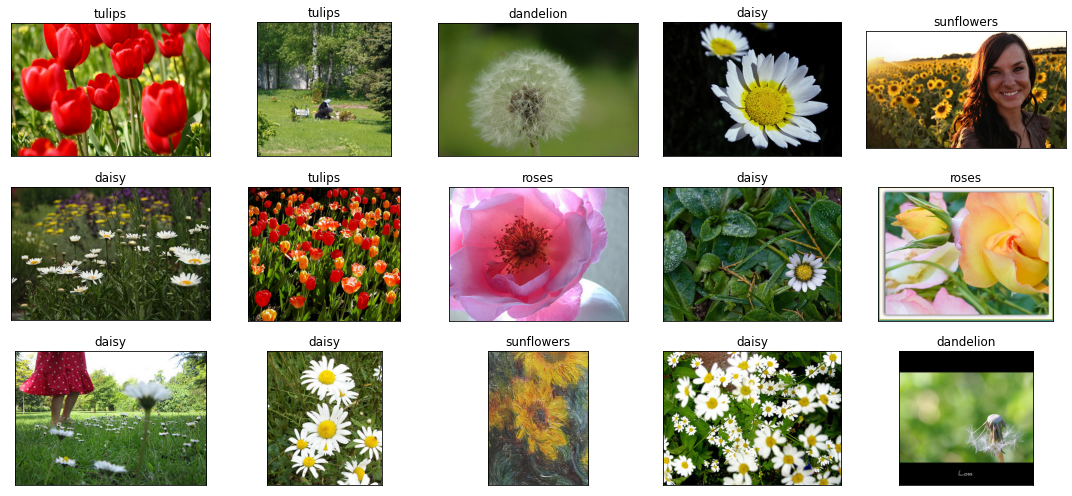

In [ ]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
test_answers = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/FlowersClassification/sample_submission.csv")

In [ ]:
test_answers['Id']= '/content/drive/MyDrive/ColabNotebooks/FlowersClassification/'+ validation_answers['Id'].astype(str)

In [ ]:
test_answers.head()

,Id,Category
0,/content/drive/MyDrive/ColabNotebooks/FlowersC...,TULIP
1,/content/drive/MyDrive/ColabNotebooks/FlowersC...,TULIP
2,/content/drive/MyDrive/ColabNotebooks/FlowersC...,ROSE
3,/content/drive/MyDrive/ColabNotebooks/FlowersC...,TULIP
4,/content/drive/MyDrive/ColabNotebooks/FlowersC...,TULIP


### **Preparing the generators for the model*

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Id',
    y_col='Category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Id',
    y_col='Category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_answers,
    x_col='Id',
    y_col='Category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2936 validated image filenames belonging to 5 classes.
Found 734 validated image filenames belonging to 5 classes.
Found 734 validated image filenames belonging to 5 classes.


### **Building the model**

In [ ]:
Net = tf.keras.applications.EfficientNetV2M(weights='imagenet', input_shape=(224,224,3), include_top=False, classes=5, pooling='avg')
Net.trainable=True 

214212608/214201816 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
  Net,
  #Dropout(0.5),
  Dense(56, activation='relu'),
  Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/FlowersClassification//model3.h5'
# Setting the conditions for early stopping and lr adjustment
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8559
Epoch 1: val_loss improved from inf to 1.28244, saving model to /content/drive/MyDrive/ColabNotebooks/FlowersClassification/model3.h5
92/92 [==============================] - 839s 9s/step - loss: 0.4273 - accuracy: 0.8559 - val_loss: 1.2824 - val_accuracy: 0.5354 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9087
Epoch 2: val_loss did not improve from 1.28244
92/92 [==============================] - 167s 2s/step - loss: 0.2736 - accuracy: 0.9087 - val_loss: 1.3582 - val_accuracy: 0.4973 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9329
Epoch 3: val_loss improved from 1.28244 to 1.13014, saving model to /content/drive/MyDrive/ColabNotebooks/FlowersClassification/model3.h5
92/92 [==============================] - 177s 2s/step - loss: 0.1958 - accuracy: 0.9329 - val_loss: 1.1301 - val_

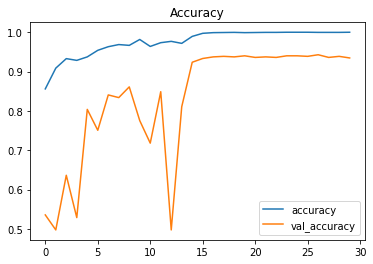

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# predicting the classes for the test images
pred = model.predict(test_images) 
pred = np.argmax(pred,axis=1)


In [ ]:
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['daisy', 'sunflowers', 'dandelion', 'tulips', 'dandelion']


### **Preparing the data for submission**

In [ ]:
result = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/FlowersClassification/sample_submission.csv")

In [ ]:
# Making the predicitons in uppercase according to the submission rules
for i in range(len(pred)):
  pred[i]=pred[i].upper()

In [ ]:
pred[:5]

['DAISY', 'SUNFLOWERS', 'DANDELION', 'TULIPS', 'DANDELION']

In [ ]:
result.head()

,Id,Category
0,flower_photos/daisy/253426762_9793d43fcd.jpg,DAISY
1,flower_photos/sunflowers/969913643_9d5cd2fe45_...,SUNFLOWERS
2,flower_photos/dandelion/7148085703_b9e8bcd6ca_...,DANDELION
3,flower_photos/tulips/141479422_5a6fa1fd1b_m.jpg,TULIPS
4,flower_photos/dandelion/8058286066_acdf082487_...,DANDELION


In [ ]:
# Adjusting pluras to singulars
result.loc[result['Category'] == 'SUNFLOWERS', 'Category'] = 'SUNFLOWER'
result.loc[result['Category'] == 'ROSES', 'Category'] = 'ROSE'
result.loc[result['Category'] == 'TULIPS', 'Category'] = 'TULIP'

In [ ]:
result.head(25)

,Id,Category
0,flower_photos/daisy/253426762_9793d43fcd.jpg,DAISY
1,flower_photos/sunflowers/969913643_9d5cd2fe45_...,SUNFLOWER
2,flower_photos/dandelion/7148085703_b9e8bcd6ca_...,DANDELION
3,flower_photos/tulips/141479422_5a6fa1fd1b_m.jpg,TULIP
4,flower_photos/dandelion/8058286066_acdf082487_...,DANDELION
5,flower_photos/tulips/13997627965_22d81601ce_n.jpg,TULIP
6,flower_photos/dandelion/5110104894_a52c685516_...,DANDELION
7,flower_photos/sunflowers/184682920_97ae41ce60_...,SUNFLOWER
8,flower_photos/tulips/2280950463_86510c2789_n.jpg,TULIP
9,flower_photos/roses/15419696882_9394168a10_n.jpg,ROSE


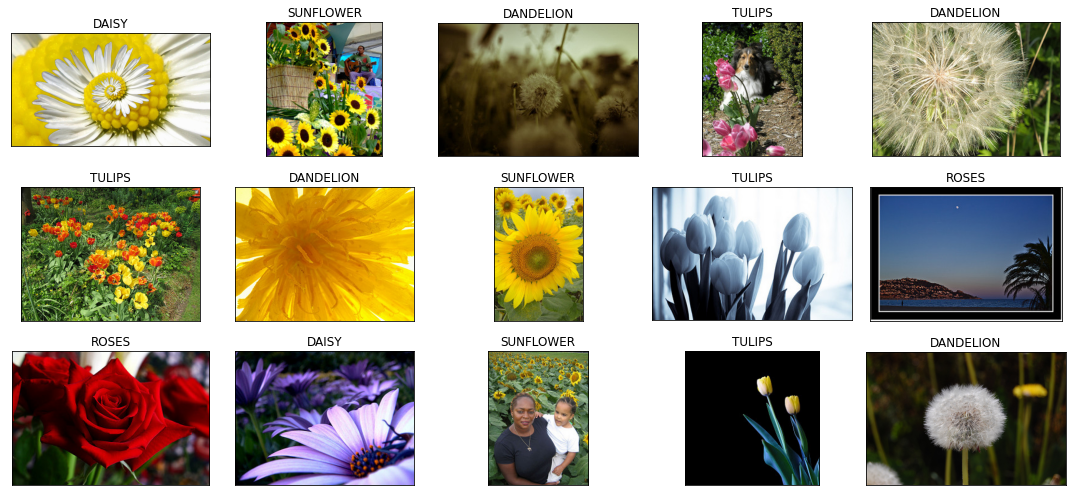

In [ ]:
# Display 15 picture of the predictions with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validation_answers.Id[i]))
    ax.set_title(result.Category[i])
plt.tight_layout()
plt.show()

In [ ]:
result.to_csv('/content/drive/MyDrive/ColabNotebooks/FlowersClassification/my_submission.csv', index = False)